# Making movies or interactive animations of the Sun

The Helioseismic and Magnetic Imager (HMI) on the Solar Dynamics Observatory takes full-disk continuum intensity, doppler velocity, and magnetic field maps of the solar surface. Here, we make a movie of the radial component of the vector magnetic field using a data product called [HMI Space-weather Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) or SHARPs. SHARPs contain partial-disk patches of the continuum intensity, doppler velocity, and magnetic field maps. These patches encapsulate automatically-detected active regions that are tracked throughout their lifetime. This notebook goes through three different ways of making movies or interactive animations.

In [52]:
%matplotlib notebook

import drms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as manimation

from datetime import datetime as dt_obj
from astropy.io import fits
from sunpy.visualization.animator import ImageAnimator

We query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the SHARP image files. The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data. Here, we're querying for the $B_z$ component of the vector magnetic field (note the variable passed to the `Seg` keyword in the url below), although we can easily query for other data products (see table A.7 in [Bobra et al., 2014](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) for segment name information). <br>

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.

In [53]:
def parse_tai_string(tstr, datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [54]:
def create_animation(harp_id, start_time, end_time, time_interval='4h'):
    '''Makes and returns movie based on params. Will sample the data every time interval.
    '''
    c = drms.Client()
    url_base = 'hmi.sharp_cea_720s'
    query_string = '[' + str(harp_id) + '][' + start_time + '-' + end_time + ']'
    if time_interval: query_string = query_string[:-1] + '@' + time_interval + ']'
    keys, segments = c.query(url_base + query_string,
                             key='NOAA_ARS, T_REC, USFLUX, ERRVF',
                             seg='Br, conf_disambig')
    t_rec = np.array([parse_tai_string(keys.T_REC[i], datetime=True) for i in range(keys.T_REC.size)])
    nz = (len(segments))
    ims = []
    for i in range(nz):
        url = 'http://jsoc.stanford.edu' + segments.Br[i]
        photosphere_image = fits.open(url)                  # download the data
        ims.append(photosphere_image[1].data)
    data_cube = np.stack((ims))
    animation = ImageAnimator(data_cube, cmap='seismic_r')
    ax = plt.gca()
    ax.set_title('Flux Emergence Over Time for Active Region ' + str(harp_id))
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    return animation

<IPython.core.display.Javascript object>


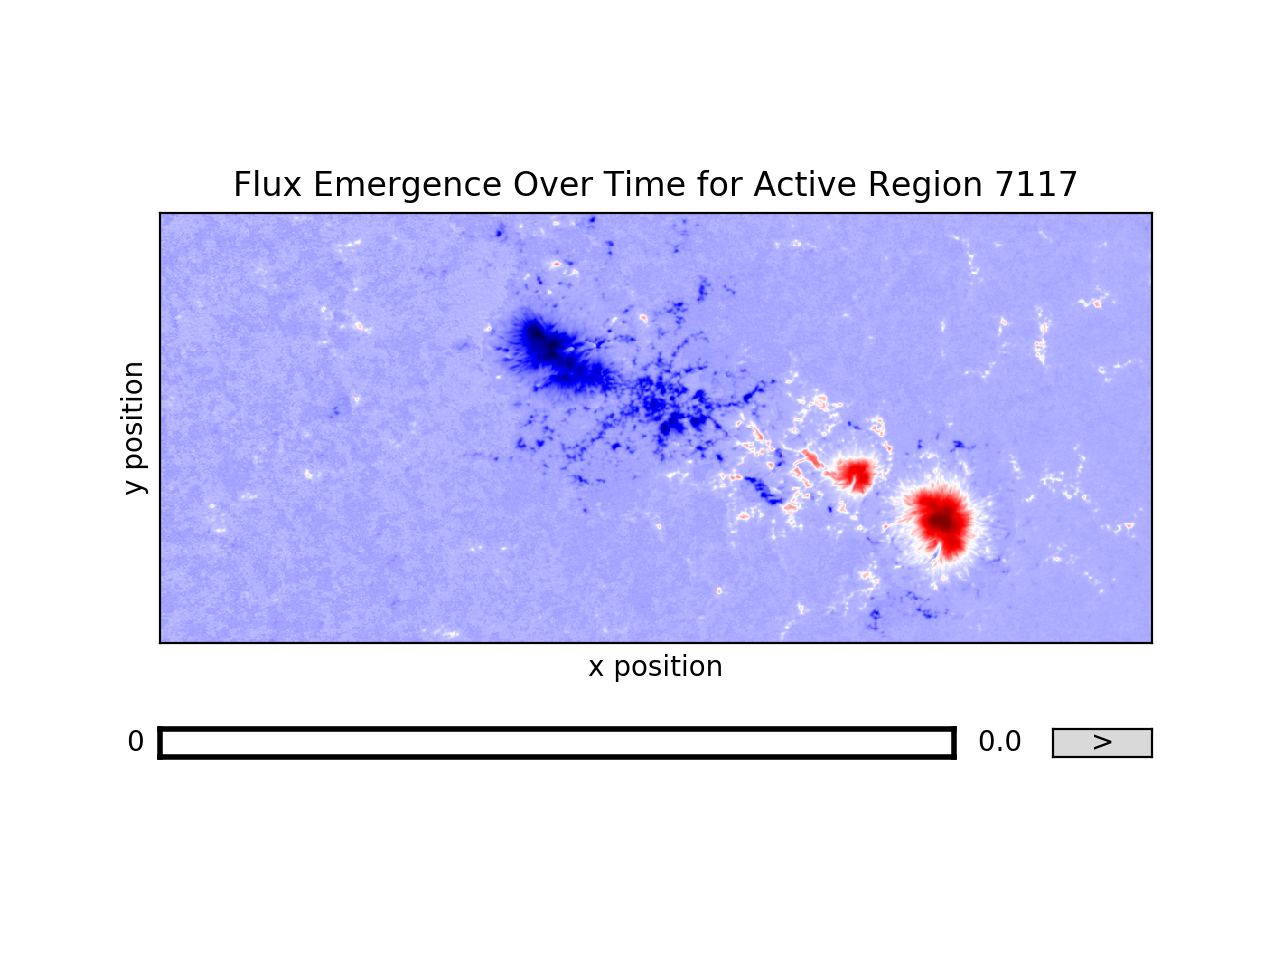

In [55]:
animation = create_animation(7117, '2017.09.03_00:00_TAI', '2017.09.06_00:00_TAI')

In [56]:
def save_animation(harp_id, start_time, end_time, time_interval='4h'):
    '''Saves a movie based on params. Will sample the data every time interval.
    '''
    c = drms.Client()
    url_base = 'hmi.sharp_cea_720s'
    query_string = '[' + str(harp_id) + '][' + start_time + '-' + end_time + ']'
    if time_interval: query_string = query_string[:-1] + '@' + time_interval + ']'
    keys, segments = c.query(url_base + query_string,
                             key='NOAA_ARS, T_REC, USFLUX, ERRVF',
                             seg='Br, conf_disambig')
    t_rec = np.array([parse_tai_string(keys.T_REC[i], datetime=True) for i in range(keys.T_REC.size)])
    nz = (len(segments))
    url = 'http://jsoc.stanford.edu' + segments.Br[0]
    photosphere_image = fits.open(url)
    ims = []

    my_dpi=192
    ny, nx = photosphere_image[1].data.shape
    fig = plt.figure(figsize=(nx/my_dpi, ny/my_dpi), dpi=my_dpi)
    ax = plt.gca()
    ax.set_title('Flux Emergence Over Time for Active Region ' + str(harp_id))
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ims = []
    for i in range(keys.T_REC.size):
        url = 'http://jsoc.stanford.edu' + segments.Br[i]
        photosphere_image = fits.open(url)
        im = plt.imshow(photosphere_image[1].data, cmap='seismic_r', origin='lower',
                        vmin=-3000, vmax=3000, extent=[0, nx, 0, ny], interpolation=None, animated=True)
        ims.append([im])

    ani = manimation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    base_dir = './movies/'
    ani.save(base_dir + str(harp_id) + '_' + start_time + '_' + end_time +'.mp4',
             writer='ffmpeg_file', dpi=my_dpi)

<IPython.core.display.Javascript object>


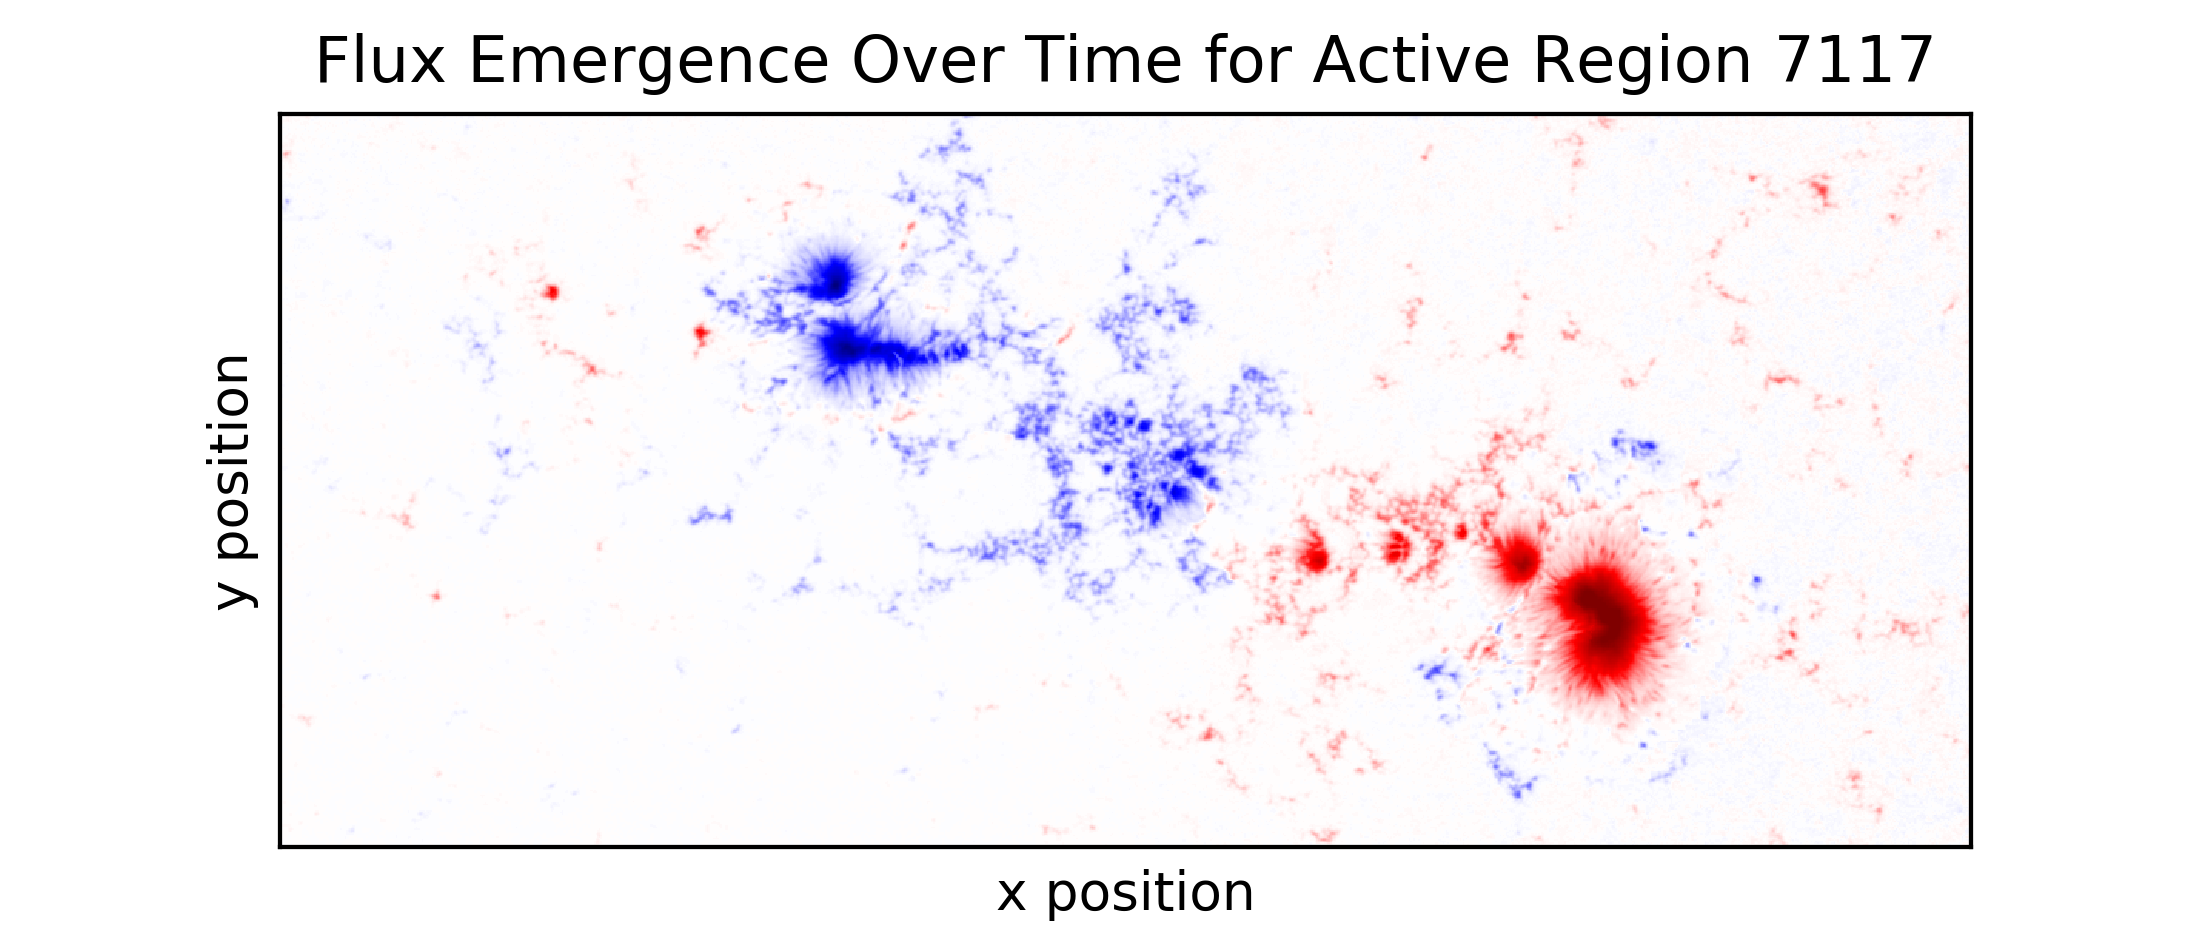

In [57]:
save_animation(7117, '2017.09.03_00:00_TAI', '2017.09.06_00:00_TAI')